# K-Means Iris dataset

In [43]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.stats import mode
import numpy as np
from sklearn.metrics import silhouette_score



In [44]:
RANDOM_SEED = 9
DATASPLIT = 0.3
DATASET_ID= 81

In [45]:
logger = logging.getLogger(str(DATASET_ID))
logging.basicConfig(level=logging.DEBUG)

In [ ]:
dataset = fetch_ucirepo(id=DATASET_ID)

df = pd.DataFrame(dataset.data.features)

label_encoder = LabelEncoder()

df['class'] = label_encoder.fit_transform(dataset.data.targets)

df = df.replace("?", pd.NA).dropna()

scaler = StandardScaler()

data = scaler.fit_transform(df)

labels = df['class']

df = df.drop(columns=['class'])



data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=DATASPLIT, random_state=RANDOM_SEED)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=DATASPLIT, random_state=RANDOM_SEED)

logger.info(f"Train dataset length: {len(data_train)}, Validation dataset length: {len(data_val)}, Test dataset length: {len(data_test)}")

print(df.head())




INFO:81:Train dataset length: 5385, Validation dataset length: 2309, Test dataset length: 3298


   Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0          47         100          27          81          57          37   
1           0          89          27         100          42          75   
2           0          57          31          68          72          90   
3           0         100           7          92           5          68   
4           0          67          49          83         100         100   

   Attribute7  Attribute8  Attribute9  Attribute10  Attribute11  Attribute12  \
0          26           0           0           23           56           53   
1          29          45          15           15           37            0   
2         100         100          76           75           50           51   
3          19          45          86           34          100           45   
4          81          80          60           60           40           40   

   Attribute13  Attribute14  Attribute15  Attribute16  


In [47]:
parameters = {
    'n_clusters': range(1, 20, 1),
    'max_iter': range(100, 500, 100),
}


clf = GridSearchCV(KMeans(random_state=RANDOM_SEED), parameters, scoring='accuracy', verbose=0)
clf.fit(data_val, label_val)

model = clf.best_estimator_
logger.info("Best cross-validation score: %f", clf.best_score_)
logger.info("With parameters: %s", clf.best_params_)

logger.info("Training model with best parameters")
model.fit(data_train, label_train)

predictions = model.predict(data_test)

   
mapped_labels = np.zeros_like(predictions)
for i in range(clf.best_params_['n_clusters']):  
    mask = (predictions == i)
    mapped_labels[mask] = mode(label_test[mask])[0]



accuracy = accuracy_score(label_test, mapped_labels)
logger.info("Accuracy: %f", accuracy)

f1 = f1_score(label_test, mapped_labels, average='weighted')
logger.info("F1 score: %f", f1)

ari = adjusted_rand_score(label_test, mapped_labels)
logger.info("ARI score: %f", ari)

sil = silhouette_score(data_test, mapped_labels)
logger.info("Silhouette score: %f", sil)


INFO:81:Best cross-validation score: 0.149910
INFO:81:With parameters: {'max_iter': 100, 'n_clusters': 6}
INFO:81:Training model with best parameters
INFO:81:Accuracy: 0.538811
INFO:81:F1 score: 0.418426
INFO:81:ARI score: 0.410045
INFO:81:Silhouette score: 0.248360


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7070a8079490>


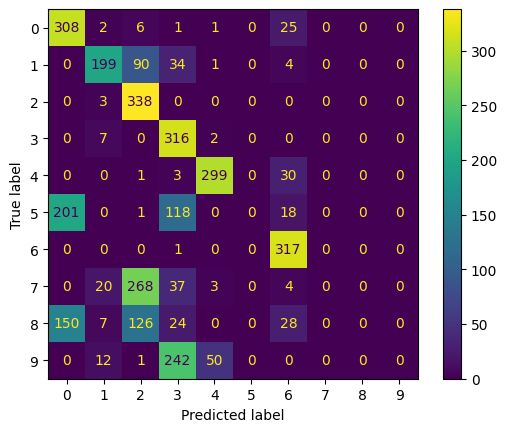

In [48]:
cm = confusion_matrix(label_test, mapped_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()


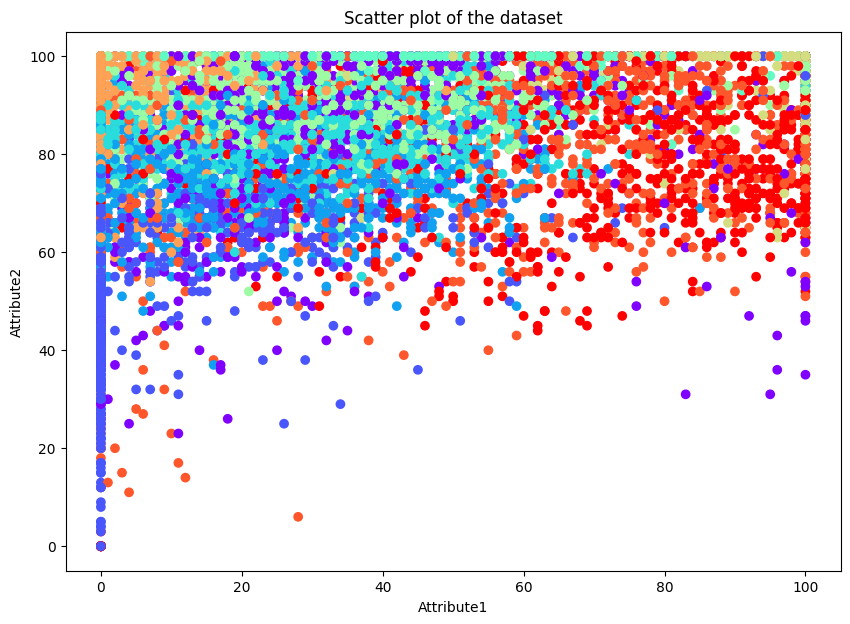

In [49]:

plt.figure(figsize=(10, 7))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels, cmap='rainbow')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Scatter plot of the dataset")
plt.show()